# Project- Recommendation Systems: Amazon product reviews

**Marks: 60**


Dear Learner,

Welcome to project on Recommendation Systems. We will work with the Amazon ptoduct reviews dataset for this project work.

Do read the problem statement and the guidelines around the same.

----
### Context: 
-------

Online E-commerce websites like Amazon, Flipkart uses different recommendation models to provide different suggestions to different users. Amazon currently uses item-to-item collaborative filtering, which scales to massive data sets and produces high-quality recommendations in real-time.

---------
### Objective:
------------
Build a recommendation system to recommend products to customers based on the their previous ratings for other products.

--------
### Dataset Attributes
------------
- userId : Every user identified with a unique id
- productId : Every product identified with a unique id
- Rating : Rating of the corresponding product by the corresponding user
- timestamp : Time of the rating ( ignore this column for this exercise)

---------------------------
### Guidelines
-----------------------------------------
- Downlod the dataset from the drive link provided to you
- The exercise consists of semi written code blocks. You need to fill the blocks (________________) as per the instructions to achieve the required results.
- To be able to complete the assessment in the expected time, do not change the variable names. The codes might throw errors when the names are changed. 
- The marks of each requirement is mentioned in the question.
- You can raise your issues on the discussion forum on the Olympus.
- Uncomment the code snippets and work on them
--------------------------------------------
Wishing you all the best!

### Data Source:
Amazon Reviews data: http://jmcauley.ucsd.edu/data/amazon/

Electronics (ratings only) dataset: This dataset includes no metadata or reviews, but only (user,Product,rating,Product Name) 

### Import Required Libraries

In [1]:
import numpy as np
import pandas as pd
import math
import json
import time
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.neighbors import NearestNeighbors

import scipy.sparse
from scipy.sparse import csr_matrix
import warnings; warnings.simplefilter('ignore')
%matplotlib inline

### Read the dataset 

In [2]:
#Import the data set
df = pd.read_csv('ratings_Electronics.csv', header=None)
df.columns = ['user_id', 'prod_id', 'rating', 'prod_name']
df = df.drop('prod_name', axis=1)
df_copy = df.copy(deep=True)

In [3]:
# see few rows of the imported dataset
df.head()

,user_id,prod_id,rating
0,AKM1MP6P0OYPR,0132793040,5.0
1,A2CX7LUOHB2NDG,0321732944,5.0
2,A2NWSAGRHCP8N5,0439886341,1.0
3,A2WNBOD3WNDNKT,0439886341,3.0
4,A1GI0U4ZRJA8WN,0439886341,1.0


### Exploratory data analysis (5 marks)

In [4]:
# Check the number of rows and columns
rows, columns = df.shape
print("No of rows: ", rows) 
print("No of columns: ", columns) 

No of rows:  7824482
No of columns:  3


In [5]:
#Check Data types
df.dtypes

user_id     object
prod_id     object
rating     float64
dtype: object

In [6]:
# Check for missing values present
print('Number of missing values across columns-\n', df.isna().sum())

Number of missing values across columns-
 user_id    0
prod_id    0
rating     0
dtype: int64


In [7]:
# Total number of missing values
df.isna().sum().sum()

0

**Observations:**
- There are 7824482 rows and 3 columns.
- user_id and prod_id are given as objects, not numbers.
- There are no missing or NaN values.

In [8]:
# Summary statistics of 'rating' variable
df['rating'].describe()

count    7.824482e+06
mean     4.012337e+00
std      1.380910e+00
min      1.000000e+00
25%      3.000000e+00
50%      5.000000e+00
75%      5.000000e+00
max      5.000000e+00
Name: rating, dtype: float64

**Observations:** 
- The mean rating is 4.01 and the median is 5. This points to a left skewed distribution.
- The minimum rating is 1 and the maximum is 5.
- The standard deviation is 1.38.

**Let's check the ratings distribution and visualize it.**

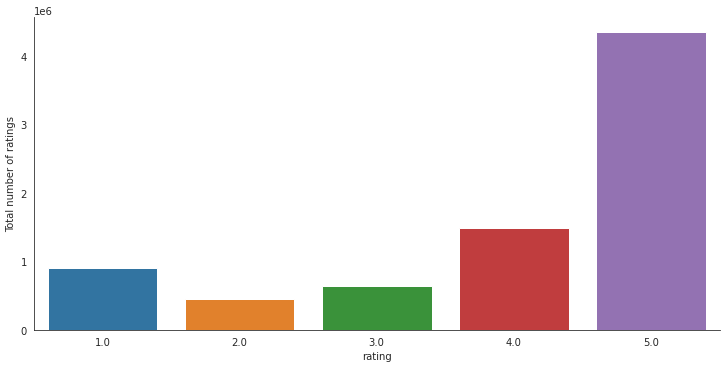

In [9]:
# Check the distribution of the ratings 
with sns.axes_style('white'):
    g = sns.factorplot("rating", data=df, aspect=2.0,kind='count')
    g.set_ylabels("Total number of ratings") 

**Let's now check the number of unique users and items in the dataset.**

In [10]:
# Number of unique user id and product id in the data
print('Number of unique USERS in Raw data = ', df['user_id'].nunique())
print('Number of unique ITEMS in Raw data = ', df['prod_id'].nunique())

Number of unique USERS in Raw data =  4201696
Number of unique ITEMS in Raw data =  476002


In [11]:
# Top 10 users based on rating
most_rated = df.groupby('user_id').size().sort_values(ascending=False)[:10]
most_rated

user_id
A5JLAU2ARJ0BO     520
ADLVFFE4VBT8      501
A3OXHLG6DIBRW8    498
A6FIAB28IS79      431
A680RUE1FDO8B     406
A1ODOGXEYECQQ8    380
A36K2N527TXXJN    314
A2AY4YUOX2N1BQ    311
AWPODHOB4GFWL     308
A25C2M3QF9G7OQ    296
dtype: int64

### Data preparation as per requirement on number of minimum ratings (1 mark)

**Let's take a subset of dataset (by only keeping the users who have given 50 or more number of ratings) to make the dataset less sparse and easy to work with.**

In [12]:
counts = df['user_id'].value_counts()
df_final = df[df['user_id'].isin(counts[counts >= 50].index)]

In [13]:
print('The number of observations in the final data =', len(df_final))
print('Number of unique USERS in the final data = ', df_final['user_id'].nunique())
print('Number of unique ITEMS in the final data = ', df_final['prod_id'].nunique())

The number of observations in the final data = 125871
Number of unique USERS in the final data =  1540
Number of unique ITEMS in the final data =  48190


**Observations:** df_final has users who have rated 50 or more items and **we will using df_final to build recommendation systems**
- The number of observations in df_final is 125871, but the original data set contained 7824482 observations. The number of data points in the final data set has been reduced a lot from the original dataset.

**Let's calculate the density of the rating matrix**

In [14]:
final_ratings_matrix = df_final.pivot(index = 'user_id', columns ='prod_id', values = 'rating').fillna(0)
print('Shape of final_ratings_matrix: ', final_ratings_matrix.shape)

given_num_of_ratings = np.count_nonzero(final_ratings_matrix)
print('given_num_of_ratings = ', given_num_of_ratings)
possible_num_of_ratings = final_ratings_matrix.shape[0] * final_ratings_matrix.shape[1]
print('possible_num_of_ratings = ', possible_num_of_ratings)
density = (given_num_of_ratings/possible_num_of_ratings)
density *= 100
print ('density: {:4.2f}%'.format(density))
final_ratings_matrix.head()

Shape of final_ratings_matrix:  (1540, 48190)
given_num_of_ratings =  125871
possible_num_of_ratings =  74212600
density: 0.17%


prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Build Popularity based Recommendation System by Averaging (10 marks)

In [15]:
# make a dataframe where you have the average rating and ratings count of each product in descending order of ratings count

# average rating
avg_rating = df_final.groupby('prod_id').mean()['rating']
# rating count
rating_cnt = df_final.groupby('prod_id').count()['rating']
# dataframe of prod_id, average rating and rating count
df_prod = pd.DataFrame({'Avg rating': avg_rating, 'Rating count': rating_cnt})
df_prod.sort_values(by='Rating count', ascending=False, inplace=True)
df_prod.head()

,Avg rating,Rating count
prod_id,,
B0088CJT4U,4.218447,206
B003ES5ZUU,4.864130,184
B000N99BBC,4.772455,167
B007WTAJTO,4.701220,164
B00829TIEK,4.436242,149


In [16]:
#defining a function to get the top n products based on highest average rating and some minimum interactions (minimum number of ratings) of that product
def top_n_products(final_rating, n, min_interaction):
    df_top_prod = final_rating[final_rating['Rating count'] > min_interaction]
    df_top_prod.sort_values(by='Avg rating', ascending=False, inplace=True)
    
    return df_top_prod.index[:n]
 

#### Recommending top 5 products based on popularity and with minimum interactions of 50

In [17]:
list(top_n_products(df_prod, 5, 50))

['B001TH7GUU', 'B003ES5ZUU', 'B0019EHU8G', 'B006W8U2MU', 'B000QUUFRW']

#### Recommending top 5 products based on popularity and with minimum interactions of 100

In [18]:
list(top_n_products(df_prod, 5, 100))

['B003ES5ZUU', 'B000N99BBC', 'B007WTAJTO', 'B002V88HFE', 'B004CLYEDC']

We have recommended the top 5 products by using popularity recommendation system.

### Build Collaborative Filtering based Recommendation System (15 marks)

**Let's first compute the user-item interactions matrix by making the userid as index**

In [19]:
interactions_matrix = df_final.pivot(index='user_id', columns='prod_id', values='rating')
interactions_matrix

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A100WO06OQR8BQ,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105S56ODHGJEK,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A105TOJ6LTVMBG,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
A10AFVU66A79Y1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
AZBXKUH4AIW3X,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZCE11PSTCH1L,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
AZMY6E8B52L2T,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


**Let's fill all the missing values by zero since cosine similarity can't work with missing values**

In [20]:
interactions_matrix.fillna(0, inplace=True)
interactions_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Here user id (index) is of the object data type. We will replacing the user id by numbers starting from 0 to 1539 (for all user ids) so that the index is of integer type and represents a user id in the same format**

In [21]:
interactions_matrix['user_index'] = np.arange(0, interactions_matrix.shape[0], 1)
interactions_matrix.set_index(['user_index'], inplace=True)

# Actual ratings given by users
interactions_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_index,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


**Let's first define a function to get similar users to a particular user**

In [22]:
# defining a function to get similar users and return the most similar users and their similarity scores
def similar_users(user_index, interactions_matrix):
    sims = []
    for user in interactions_matrix.index:
        cos_sim = cosine_similarity([interactions_matrix.iloc[user_index]], [interactions_matrix.iloc[user]])
        sims.append((user, cos_sim))
        
    sims.sort(key=lambda x: x[1], reverse=True)   # sort by cosine similarity
    simcosvals = [tup[1] for tup in sims]   # cosine similarity
    simusers= [tup[0] for tup in sims]      # users
    simusers.remove(user_index)             # remove user_index
    simcosvals.remove(simcosvals[0])        # remove 1
    
    return simusers, simcosvals

#### Finding out top 10 similar users to the user index 3 and their similarity score

In [23]:
similar = similar_users(3, interactions_matrix)[0][0:10]
similar

[320, 12, 793, 261, 156, 1493, 1250, 567, 753, 1360]

In [24]:
# printing the original user ids associated with the above user index
for i in similar:
    print(final_ratings_matrix.index[i])

A1TQBAHI3M4ZBQ
A10ZFE6YE0UHW8
A2XXBZPQT5EXHV
A1NZLRAZJGD99W
A1D27BCSYV7VWH
AVTJEWTCJ3PBE
AAK6SOEJY30YG
A2GKMXRLI7KLFP
A2VCXIAWCPQ13P
AKSFZ4G1AXYFC


In [25]:
#Print the similarity score
similar_users(3, interactions_matrix)[1][0:10]

[array([[0.05662371]]),
 array([[0.05549645]]),
 array([[0.05098326]]),
 array([[0.05024185]]),
 array([[0.05003874]]),
 array([[0.04930111]]),
 array([[0.04889354]]),
 array([[0.04672744]]),
 array([[0.04637283]]),
 array([[0.04492668]])]

#### Finding out top 10 similar users to the user index 1521 and their similarity score

In [26]:
similar = similar_users(1521, interactions_matrix)[0][0:10]
similar

[991, 1065, 1012, 1402, 1371, 1278, 1518, 692, 785, 161]

In [27]:
# printing the original user ids associated with the above user index
for i in similar:
    print(final_ratings_matrix.index[i])

A3FBM0RMCMAABV
A3MUSWDCTZINQZ
A3HQAPXAJV7PRX
AO09RWV40IX78
ALQ4USPEQ9L5N
ACSX5AIZE3MJ9
AY3D7DG5L5WCK
A2QDOJFFLFGF18
A2XIOXRRYX0KZY
A1DSRM2P0WGQNS


In [28]:
#Print the similarity score
similar_users(1521, interactions_matrix)[1][0:10]

[array([[0.10889304]]),
 array([[0.10538068]]),
 array([[0.1026758]]),
 array([[0.09418291]]),
 array([[0.09149062]]),
 array([[0.09135361]]),
 array([[0.09028898]]),
 array([[0.08735684]]),
 array([[0.08673386]]),
 array([[0.08478815]])]

We have found 10 similar users by using similarity based collaboartive filtering.

**To build a more robust similar user identification, we can also put a threshold to the similarity score.**

In [29]:
# defining the recommendations function to get recommendations by using the similar users preferences and return the recommendations of products

def recommendations(uid, n, interactions_matrix):
    # similar users
    simusers = similar_users(uid, interactions_matrix)[0]
    # products rated by user uid
    prod_id = set(list(interactions_matrix.columns[np.where(interactions_matrix.iloc[uid]>0)]))
    interacted_prod = prod_id.copy() # interacted products
    recommended = [] # recommendations
    # using a threshold rating of > 0
    
    while (len(recommended) < n): # while recommendations < specified number 
        # iterate over similar users
        for user in simusers:
            # add products rated by similar users to the recommendations
            simuser_pid = set(list(interactions_matrix.columns[np.where(interactions_matrix.iloc[user]>0)]))
            recommended.extend(list(simuser_pid.difference(interacted_prod)))
            # add to interacted products 
            interacted_prod= interacted_prod.union(simuser_pid)
            
    return recommended[:n]
        
            

#### Recommend 5 products to user index 3 based on similarity based collaborative filtering

In [30]:
recommendations(3, 5, interactions_matrix)

['B004LRO7FW', 'B001GCQ3KM', 'B001GUW2PY', 'B003RYJS90', 'B000TXEE14']

#### Recommend 5 products to user index 1521 based on similarity based collaborative filtering

In [31]:
recommendations(1521, 5, interactions_matrix)

['B004SNCZ3K', 'B009O7XGCY', 'B008DWCRQW', 'B00A7PPLP2', 'B0040YFPSO']

### Build Model-based Collaborative Filtering: Singular Value Decomposition (15 marks)

**SVD is best to apply on a large sparse matrix. Note that for sparse matrices, you can use the sparse.linalg.svds() function to perform the decomposition**

In [32]:
from scipy.sparse.linalg import svds # for sparse matrices
# Singular Value Decomposition
U, sigma, Vt = svds(interactions_matrix, k = 50) # here the number of latent features are 50. 
# Construct diagonal array in SVD
sigma = np.diag(sigma)

In [33]:
#checking the shape of the U matrix
U.shape

(1540, 50)

In [34]:
#checking the shape of the sigma matrix
sigma.shape

(50, 50)

In [35]:
#checking the shape of the Vt matrix
Vt.shape

(50, 48190)

In [36]:
all_user_predicted_ratings = np.dot(np.dot(U, sigma), Vt) 

# Create a dataframe of predicted ratings (all_user_predicted_ratings) by using the columns from interactions_matrix
preds_df = pd.DataFrame(data=all_user_predicted_ratings, columns=interactions_matrix.columns)
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [37]:
preds_df.shape # users and items

(1540, 48190)

In [38]:
# Define a function to recommend items with the highest predicted ratings

def recommend_items(user_index, interactions_matrix, preds_df, num_recommendations):
      
    user_idx = user_index-1 # index starts at 0
    
    # Get and sort the user's ratings
    
    #sorted_user_ratings
    sorted_user_ratings = interactions_matrix.iloc[user_idx].sort_values(ascending=False)
    
    #sorted_user_predictions
    sorted_user_predictions = preds_df.iloc[user_idx].sort_values(ascending=False)
    
    #Concatenate the sorted user ratings and sorted user predictions with the axis 1
    temp = pd.concat([sorted_user_ratings, sorted_user_predictions], axis=1)
    temp.index.name = 'Recommended Items'
    temp.columns = ['user_ratings', 'user_predictions']
    
    temp = temp.loc[temp.user_ratings == 0]   
    temp = temp.sort_values('user_predictions', ascending=False)
    print('\nBelow are the recommended items for user(user_index = {}):\n'.format(user_index))
    print(temp.head(num_recommendations))

**Recommending the 5 products to user index 121 based on this model**

In [39]:
#Enter 'user_index' and 'num_recommendations' for the user #
user_index = 121
num_recommendations = 5
recommend_items(user_index, interactions_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_index = 121):

                   user_ratings  user_predictions
Recommended Items                                
B000LRMS66                  0.0          0.543927
B002WE4HE2                  0.0          0.423175
B000KO0GY6                  0.0          0.416801
B001XURP7W                  0.0          0.356788
B005HMKKH4                  0.0          0.352138


**Recommending the 5 products to user index 465 based on this model**

In [40]:
#Enter 'user_index' and 'num_recommendations' for the user #
user_index = 465
num_recommendations = 5
recommend_items(user_index, interactions_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_index = 465):

                   user_ratings  user_predictions
Recommended Items                                
B002SZEOLG                  0.0          1.952212
B004CLYEE6                  0.0          1.820082
B004CLYEFK                  0.0          1.720494
B004CLYEH8                  0.0          1.489312
B009SYZ8OC                  0.0          1.356999


### Evaluate the model. (10 marks)

#### Evaluation of Model-based Collaborative Filtering (SVD)

In [41]:
# Actual final ratings given by the users
final_ratings_matrix.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
user_id,,,,,,,,,,,,,,,,,,,,,
A100UD67AHFODS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A100WO06OQR8BQ,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105S56ODHGJEK,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A105TOJ6LTVMBG,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
A10AFVU66A79Y1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
# Average ACTUAL rating for each item
final_ratings_matrix.mean()

prod_id
0594451647    0.003247
0594481813    0.001948
0970407998    0.003247
0972683275    0.012338
1400501466    0.012987
                ...   
B00LED02VY    0.002597
B00LGN7Y3G    0.003247
B00LGQ6HL8    0.016234
B00LI4ZZO8    0.005844
B00LKG1MC8    0.003247
Length: 48190, dtype: float64

In [43]:
# Predicted ratings 
preds_df.head()

prod_id,0594451647,0594481813,0970407998,0972683275,1400501466,1400501520,1400501776,1400532620,1400532655,140053271X,...,B00L5YZCCG,B00L8I6SFY,B00L8QCVL6,B00LA6T0LS,B00LBZ1Z7K,B00LED02VY,B00LGN7Y3G,B00LGQ6HL8,B00LI4ZZO8,B00LKG1MC8
0,0.005086,0.002178,0.003668,-0.040843,0.009640,0.006808,0.020659,0.000649,0.020331,0.005633,...,0.000238,-0.061477,0.001214,-0.123433,0.028490,0.016109,0.002855,-0.174568,0.011367,-0.012997
1,0.002286,-0.010898,-0.000724,0.130259,0.007506,-0.003350,0.063711,-0.000674,0.016111,-0.002433,...,-0.000038,0.013766,0.001473,0.025588,-0.042103,0.004251,0.002177,-0.024362,-0.014765,0.038570
2,-0.001655,-0.002675,-0.007355,0.007264,0.005152,-0.003986,-0.003480,0.006961,-0.006606,-0.002719,...,-0.001708,-0.051040,0.000325,-0.054867,0.017870,-0.004996,-0.002426,0.083928,-0.112205,0.005964
3,0.001856,0.011019,-0.005910,-0.014134,0.000179,0.001877,-0.005391,-0.001709,0.004968,0.001402,...,0.000582,-0.009326,-0.000465,-0.048315,0.023302,0.006790,0.003380,0.005460,-0.015263,-0.025996
4,0.001115,-0.002670,0.011018,0.014434,0.010319,0.006002,0.017151,0.003726,0.001404,0.005645,...,0.000207,0.023761,0.000747,-0.019347,-0.012749,0.001026,0.001364,-0.020580,0.011828,0.012770


In [44]:
# Average PREDICTED rating for each item
preds_df.mean()

prod_id
0594451647    0.001953
0594481813    0.002875
0970407998    0.003355
0972683275    0.010343
1400501466    0.004871
                ...   
B00LED02VY    0.001008
B00LGN7Y3G    0.002188
B00LGQ6HL8    0.013885
B00LI4ZZO8    0.005570
B00LKG1MC8    0.001912
Length: 48190, dtype: float64

In [45]:
#creating a dataframe containing average actual ratings and average predicted ratings based on the items
rmse_df = pd.concat([final_ratings_matrix.mean(), preds_df.mean()], axis=1)
rmse_df.columns = ['Avg_actual_ratings', 'Avg_predicted_ratings']
print(rmse_df.shape)
rmse_df['item_index'] = np.arange(0, rmse_df.shape[0], 1)
rmse_df.head()

(48190, 2)


,Avg_actual_ratings,Avg_predicted_ratings,item_index
prod_id,,,
0594451647,0.003247,0.001953,0
0594481813,0.001948,0.002875,1
0970407998,0.003247,0.003355,2
0972683275,0.012338,0.010343,3
1400501466,0.012987,0.004871,4


In [46]:
# Calculating RMSE
RMSE = np.sqrt((sum((rmse_df['Avg_actual_ratings']-rmse_df['Avg_predicted_ratings'])**2))/rmse_df.shape[0] )
print('\nRMSE SVD Model = {} \n'.format(RMSE))


RMSE SVD Model = 0.002747518546260604 



### Let's recommend 10 products to the user index 200. (2 marks)

In [47]:
# Enter 'user_index' and 'num_recommendations' for the user #
user_index = 200
num_recommendations = 10 
recommend_items(user_index, interactions_matrix, preds_df, num_recommendations)


Below are the recommended items for user(user_index = 200):

                   user_ratings  user_predictions
Recommended Items                                
B008X9Z8NE                  0.0          1.141688
B0079UAT0A                  0.0          1.101302
B008X9Z528                  0.0          1.072300
B004CLYEFK                  0.0          1.025798
B008X9Z7N0                  0.0          1.002051
B008ULPE70                  0.0          0.923480
B00BOHNYTW                  0.0          0.763110
B007WTAJTO                  0.0          0.761852
B00DQZOD8Q                  0.0          0.733176
B00A7PPLP2                  0.0          0.715661


### Summarise your insights. (2 marks)

In this project the following recommendation systems were used:
- Popularity based: recommend the products having at least a certain minimum number of ratings based on highest average rating.
- Collaborative filtering based on similar users calculated by cosine similarity: recommend products rated by similar users.
- SVD based collaborative filtering: use SVD prediction. 50 latent features were used here in SVD. Products were recommended to the user from among the products that had not been rated by the user, based on SVD predictions with highest predicted rating. RMSE between actual and predicted ratings is small.

These methods were applied to recommend products that the user had not previously interacted with.